### Model selection for testing

#### From previous result.

We have selected models that had best validation accuracy of more than 95%. Only the AdaBelief optimizer used model crossed validation score of 95% thus, all the model listed are Ada-Belief optimizer used models.

##### List of those models are:
1. ViT16 Version 3 -- 95.0% Validation Accuracy
2. ViT16 Version 4 -- 95.1% Validation Accuracy
3. ViT16 Version 6 -- 95.2% Validation Accuracy
4. ViT32 Version 4 -- 95.2% Validation Accuracy
5. ViT32 Version 5 -- 95.1% Validation Accuracy
6. ViT32 Version 6 -- 95.6% Validation Accuracy


From, confusion matrix analysis, 4 models are further selected for further tests.
ViT16 Version 4 and 6, and ViT32 Version 5 and 6. Because the False prediction from these models are comparitively lower. Specifically, other classes were predicted falsely as class 2 by most of the models thus the one with the least false prediction has been selected. 

Following models are selected for further ensembling and testing.
1. ViT16, Version 4
2. ViT16, Version 6
3. ViT32, Version 5
4. ViT32, Version 6

In [3]:
import os
assert os.path.exists("/kaggle/input/vit16-version4/model_best.pth.tar"), "Add ViT16 Version 4 Model"
assert os.path.exists("/kaggle/input/vit16-version6/model_best.pth.tar"), "Add ViT16 Version 6 Model" 
assert os.path.exists("/kaggle/input/vit32version5/model_best.pth.tar"), "Add ViT32 Version 5 Model"
assert os.path.exists("/kaggle/input/vit32version6/model_best.pth.tar"), "Add ViT32 Version 6 Model" 

In [4]:
!pip install timm

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import timm

import gc
import os
import time
import random
from datetime import datetime
import shutil

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics
from shutil import copyfile

In [6]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(111)

In [7]:
# general global variables
DATA_PATH = "/kaggle/input/pollen-dataset/Pollen_data"
IMAGES_PATH = os.path.join(DATA_PATH, "images")
df = pd.read_csv(os.path.join(DATA_PATH, "data.csv"))

# Here for splitting the data into train, test and validation. We will using train_test_split from sklearn

# First divide the data into train data (80%) and remaining data(20%)
# Second divide the remaining data into validation (10%) and test data(10%)
train_df, remaining_df = model_selection.train_test_split(df, test_size=0.2, random_state=42, stratify=df.label.values)
# Dividing remaining data into validation and test set
valid_df, test_df = model_selection.train_test_split(remaining_df, test_size=0.5, random_state=42, stratify=remaining_df.label.values)

In [8]:
from torch.utils.data import DataLoader
class PollenDataset(torch.utils.data.Dataset):
    """
    Helper Class to create the pytorch dataset
    """

    def __init__(self, df, data_path=DATA_PATH, transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.data_dir = "images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        label = np.asarray(label, dtype='int64')

        if self.transforms is not None:
            image = self.transforms(img)

        return image, torch.from_numpy(label)

In [9]:
IMG_SIZE = 224
BATCH_SIZE = 16

In [10]:
# create image transformations
transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [11]:
# Train and validation dataset with transformations
valid_dataset = PollenDataset(valid_df, transforms=transforms_valid)
test_dataset = PollenDataset(test_df, transforms=transforms_valid)
# validation loader 
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
    )
# test loader 
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
    )

In [12]:
# VIT model with patch16
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained)
        self.model.head = nn.Linear(self.model.head.in_features, n_classes) # Classification head

    def forward(self, x):
        x = self.model(x)
        return x  

# VIT model with patch32
class ViTBase32(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase32, self).__init__()
        
        self.model = timm.create_model("vit_base_patch32_224", pretrained)
        self.model.head = nn.Linear(self.model.head.in_features, n_classes) # Classification head

    def forward(self, x):
        x = self.model(x)
        return x

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:
criterion = nn.CrossEntropyLoss()

### Performance measure of best models

In [15]:
ROOT_PATH = "/kaggle/input/"
model_rel_paths = ["vit16-version4/model_best.pth.tar", "vit16-version6/model_best.pth.tar", "vit32version5/model_best.pth.tar", "vit32version6/model_best.pth.tar"]

model_paths = [os.path.join(ROOT_PATH, i) for i in model_rel_paths]
model_paths

['/kaggle/input/vit16-version4/model_best.pth.tar',
 '/kaggle/input/vit16-version6/model_best.pth.tar',
 '/kaggle/input/vit32version5/model_best.pth.tar',
 '/kaggle/input/vit32version6/model_best.pth.tar']

In [16]:
for i in model_paths:
    assert os.path.exists(i), "Add {} Model".format(i.split('/')[3]) 

In [17]:
model_paths

['/kaggle/input/vit16-version4/model_best.pth.tar',
 '/kaggle/input/vit16-version6/model_best.pth.tar',
 '/kaggle/input/vit32version5/model_best.pth.tar',
 '/kaggle/input/vit32version6/model_best.pth.tar']

In [18]:
def load_model(model_path):
    base_class_number = int(model_path.split('/')[3][3:5])
    if base_class_number == 16:
        model = ViTBase16(n_classes=4, pretrained=False)
    elif base_class_number == 32:
        model = ViTBase32(n_classes=4, pretrained=False)
    else:
        print("Only suitable for 16 or 32 Base type")
        return
    
    model.load_state_dict(torch.load(model_path)['state_dict'])
    model = model.to(device)
    return model

In [19]:
models = [load_model(i) for i in model_paths]
print("All Models loaded in the models list")

All Models loaded in the models list


In [20]:
len(models)

4

In [22]:
def validation_evaluation(model):
    print("######### Evaluation on Validation Set ########")
    prediction = []
    ground_truth = []
    with torch.no_grad():
        model.eval()
        out = nn.Softmax(dim=1)
        for data, target in valid_loader:
            data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64)
            output = model(data)
            soft = out(output)
            soft = soft.cpu().numpy()
#             print(torch.round(soft*100))
            prediction.extend(soft)
            ground_truth.extend(target)
    return prediction, ground_truth

In [23]:
val_predictions = {}

for model_number, model in enumerate(models):
    prediction, gt = validation_evaluation(model)
    val_predictions[model_number+1] = prediction

######### Evaluation on Validation Set ########
######### Evaluation on Validation Set ########
######### Evaluation on Validation Set ########
######### Evaluation on Validation Set ########


In [24]:
ground_truth_array = [int(i.cpu().detach().numpy()) for i in gt]

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
from itertools import combinations

In [26]:
def evaluation_metrics(val_predictions, ground_truth_array):
    for i in range(1, len(val_predictions.keys())+1):
        combination = combinations(val_predictions.keys(), i)
        for c in combination:
            print("Models are {}".format(c))
            temp_array = np.zeros((1128, 4))
            for i in range(len(c)):
                temp_array += np.array(val_predictions[c[i]])
            prediction = temp_array.argmax(axis=1)
            print(classification_report(ground_truth_array, prediction, digits=6))
            print(confusion_matrix(ground_truth_array, prediction))
            print("##############################################################")


evaluation_metrics(val_predictions, ground_truth_array)

Models are (1,)
              precision    recall  f1-score   support

           0   0.881250  0.903846  0.892405       156
           1   0.934211  0.910256  0.922078        78
           2   0.963899  0.975639  0.969734       821
           3   0.967213  0.808219  0.880597        73

    accuracy                       0.950355      1128
   macro avg   0.936643  0.899490  0.916203      1128
weighted avg   0.950630  0.950355  0.949975      1128

[[141   0  15   0]
 [  2  71   4   1]
 [ 17   2 801   1]
 [  0   3  11  59]]
##############################################################
Models are (2,)
              precision    recall  f1-score   support

           0   0.901961  0.884615  0.893204       156
           1   0.873563  0.974359  0.921212        78
           2   0.966143  0.973203  0.969660       821
           3   0.983607  0.821918  0.895522        73

    accuracy                       0.951241      1128
   macro avg   0.931318  0.913524  0.919900      1128
weighted avg 

### Selecting the Best Ensembled Validation Model for testing

Following combination has the best model performance.

Selecting only models combination having accuracy over 96.3%

| Model Combination  | F1 Weighted| F1 Macro| Accuracy|
|:------------------:|:----------:|:-------:|:-------:|
|      1,2,3,4       |0.964086    | 0.944076| 0.964539|
|      1,3,4         |0.964014    | 0.943716| 0.964539|
|      1, 4          |0.963240    | 0.940885| 0.963652|



In [27]:
def test_evaluation(model):
    print("######### Evaluation on Test Set ########")
    prediction = []
    ground_truth = []
    with torch.no_grad():
        model.eval()
        out = nn.Softmax(dim=1)
        for data, target in test_loader:
            data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.int64)
            output = model(data)
            soft = out(output)
            soft = soft.cpu().numpy()
            prediction.extend(soft)
            ground_truth.extend(target)
    return prediction, ground_truth

In [28]:
test_predictions = {}
for model_number, model in enumerate(models):
    prediction, gt = test_evaluation(model)
    test_predictions[model_number+1] = prediction

######### Evaluation on Test Set ########
######### Evaluation on Test Set ########
######### Evaluation on Test Set ########
######### Evaluation on Test Set ########


In [30]:
test_ground_truth_array = [int(i.cpu().detach().numpy()) for i in gt]

In [31]:
def plot_cm(ground_truth_array, prediction_array):
    import seaborn as sns
    cm = confusion_matrix(ground_truth_array, prediction_array)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title("Confusion Matrix on Test set")
    sns.heatmap(cmn, annot=True, fmt='.2f')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

Models are (1, 4)
              precision    recall  f1-score   support

           0   0.888158  0.859873  0.873786       157
           1   0.955224  0.831169  0.888889        77
           2   0.952830  0.982968  0.967665       822
           3   0.983607  0.833333  0.902256        72

    accuracy                       0.945922      1128
   macro avg   0.944955  0.876836  0.908149      1128
weighted avg   0.945957  0.945922  0.945046      1128

[[135   0  22   0]
 [  3  64   9   1]
 [ 12   2 808   0]
 [  2   1   9  60]]


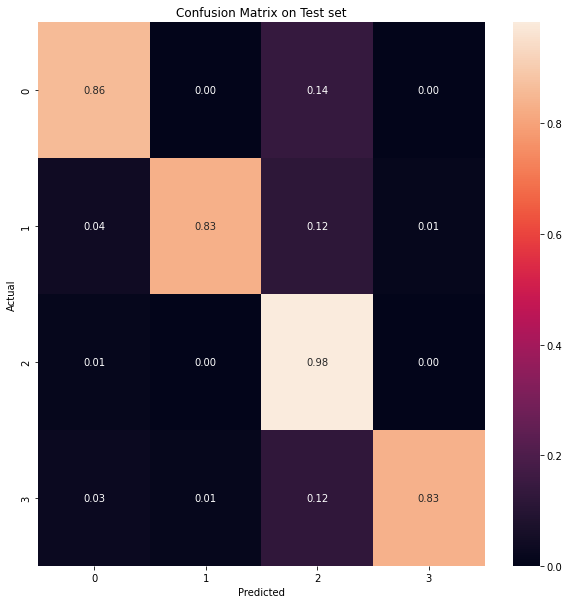

##############################################################
Models are (1, 3, 4)
              precision    recall  f1-score   support

           0   0.912162  0.859873  0.885246       157
           1   0.955224  0.831169  0.888889        77
           2   0.952941  0.985401  0.968900       822
           3   0.968254  0.847222  0.903704        72

    accuracy                       0.948582      1128
   macro avg   0.947145  0.880916  0.911685      1128
weighted avg   0.948399  0.948582  0.947633      1128

[[135   0  22   0]
 [  2  64   9   2]
 [ 10   2 810   0]
 [  1   1   9  61]]


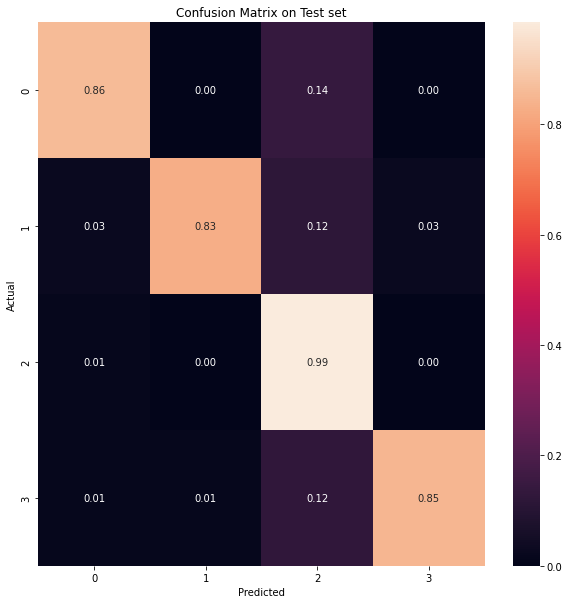

##############################################################
Models are (1, 2, 3, 4)
              precision    recall  f1-score   support

           0   0.918367  0.859873  0.888158       157
           1   0.942029  0.844156  0.890411        77
           2   0.952941  0.985401  0.968900       822
           3   0.983871  0.847222  0.910448        72

    accuracy                       0.949468      1128
   macro avg   0.949302  0.884163  0.914479      1128
weighted avg   0.949358  0.949468  0.948573      1128

[[135   0  22   0]
 [  2  65   9   1]
 [  9   3 810   0]
 [  1   1   9  61]]


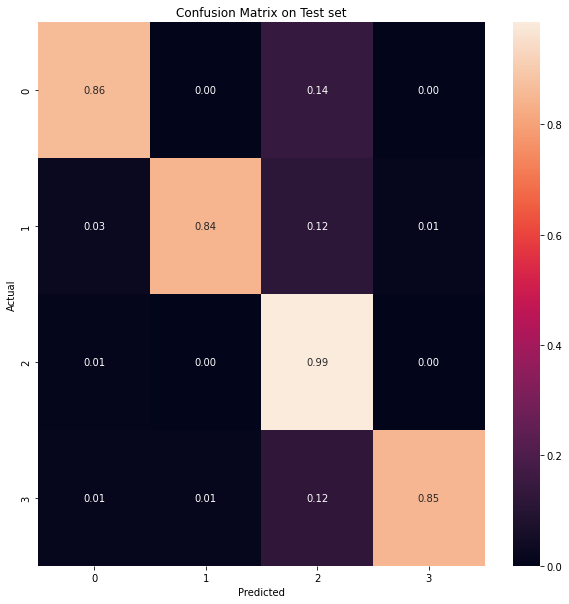

##############################################################


In [32]:
def test_metrics(test_predictions, test_ground_truth_array):
    selected_combinations = ((1,4), (1,3,4), (1,2,3,4))
    for c in selected_combinations:
        print("Models are {}".format(c))
        temp_array = np.zeros((1128, 4))
        for i in range(len(c)):
            temp_array += np.array(test_predictions[c[i]])
        prediction = temp_array.argmax(axis=1)
        print(classification_report(test_ground_truth_array, prediction, digits=6))
        print(confusion_matrix(test_ground_truth_array, prediction))
        plot_cm(test_ground_truth_array, prediction)
        print("##############################################################")


test_metrics(test_predictions, test_ground_truth_array)